# Evolving vector-space model

This lab will be devoted to the use of `doc2vec` model for the needs of information retrieval and text classification.  

## 1. Searching in the curious facts database
The facts dataset is given [here](https://github.com/hsu-ai-course/hsu.ai/blob/master/code/datasets/nlp/facts.txt), take a look.  We want you to retrieve facts relevant to the query, for example, you type "good mood", and get to know that Cherophobia is the fear of fun. For this, the idea is to utilize document vectors. However, instead of forming vectors with tf-idf and reducing dimensions, this time we want to obtain fixed-size vectors for documents using `doc2vec` model.

### 1.1 Loading trained `doc2vec` model

First, let's load the pre-trained `doc2vec` model from https://github.com/jhlau/doc2vec (Associated Press News DBOW (0.6GB))

In [1]:
!pip install gensim

In [2]:
from gensim.models.doc2vec import Doc2Vec

# unpack a model into 3 files and target the main one
# doc2vec.bin  <---------- this
# doc2vec.bin.syn0.npy
# doc2vec.bin.sin1neg.npy
model = Doc2Vec.load('apnews_dbow/doc2vec.bin', mmap=None)
print(type(model))
print(type(model.infer_vector(["to", "be", "or", "not"])))
print(model.infer_vector(["to", "be", "or", "not"]).shape)

<class 'gensim.models.doc2vec.Doc2Vec'>
<class 'numpy.ndarray'>
(300,)


### 1.2 Reading data

Now, let's read the facts dataset. Download it from the abovementioned url and read to the list of sentences.

In [3]:
#TODO read facts into list
import requests


file_link = 'https://raw.githubusercontent.com/hsu-ai-course/hsu.ai/master/code/datasets/nlp/facts.txt'
content = requests.get(file_link).content.decode('utf-8', errors='ignore')
remove_enumeration = False
if remove_enumeration:
    facts = [x[x.find(' ') + 1:] for x in content.splitlines()]
else:
    facts = [x for x in content.splitlines()]
facts[:5]

['1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.',
 '2. McDonalds calls frequent buyers of their food heavy users.',
 '3. The average person spends 6 months of their lifetime waiting on a red light to turn green.',
 '4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.',
 '5. You burn more calories sleeping than you do watching television.']

### 1.3 Tests

In [4]:
print(*facts[:5], sep='\n')

assert len(facts) == 159
assert ('our lovely little planet') in facts[0]

1. If you somehow found a way to extract all of the gold from the bubbling core of our lovely little planet, you would be able to cover all of the land in a layer of gold up to your knees.
2. McDonalds calls frequent buyers of their food heavy users.
3. The average person spends 6 months of their lifetime waiting on a red light to turn green.
4. The largest recorded snowflake was in Keogh, MT during year 1887, and was 15 inches wide.
5. You burn more calories sleeping than you do watching television.


### 1.4  Transforming sentences to vectors

Transform the list of facts to numpy array of vectors corresponding to each document (`sent_vecs`), inferring them from the model we just loaded.

In [5]:
#TODO infer vectors
import numpy as np

sent_vecs = np.array([model.infer_vector(sent.split()) for sent in facts])

### 1.5 Tests 

In [6]:
print(sent_vecs.shape)
assert sent_vecs.shape == (159, 300)

(159, 300)


### 1.6 Find closest

Now, reusing the code from the last lab, find facts which are closest to the query using cosine similarity measure.

In [7]:
#TODO output closest facts to the query
def cosine_similarity(v, u):
    return np.sum(np.multiply(v, u)) / np.linalg.norm(v) / np.linalg.norm(u)

def find_k_closest(query, dataset, k=5):    
    query_vec = model.infer_vector(query.split())
    similarities = [(i, sent_vec, cosine_similarity(query_vec, sent_vec)) for i, sent_vec in enumerate(dataset)]
    similarities.sort(key = lambda x: x[-1], reverse=True)
    return similarities[:k]
    

query = "good mood"
print("Results for query:", query)
r = find_k_closest(query, sent_vecs, 5)
for k, v, p in r:
    print("\t", facts[k], "sim=", p)

Results for query: good mood
	 144. Dolphins sleep with one eye open! sim= 0.65879935
	 57. Gorillas burp when they are happy sim= 0.59512585
	 111. Butterflies taste their food with their feet. sim= 0.5932894
	 141. Months that begin on a Sunday will always have a Friday the 13th. sim= 0.5911027
	 98. Blue-eyed people tend to have the highest tolerance of alcohol. sim= 0.57972896


## 2. Training doc2vec model and documents classifier

Now we would like you to train doc2vec model yourself based on [this topic-modeling dataset](https://code.google.com/archive/p/topic-modeling-tool/downloads).

### 2.1 Read dataset

First, read the dataset - it consists of 4 parts, you need to merge them into single list. 

In [3]:
import os

all_data = []
labels = []

folder_name = 'topic-modeling-tool'
topics = ('braininjury', 'news_economy', 'news_fuel', 'news_music')
for topic in topics:
    file_name = f'testdata_{topic}.txt'
    file = open(f'{folder_name}/{file_name}', 'r')
    new_data = file.readlines()
    all_data += new_data
    labels += [topic] * len(new_data)

### 2.2 Tests 

In [4]:
print(len(all_data))
assert len(all_data) == 15002

15002


### 2.3 Training `doc2vec` model

Train a `doc2vec` model based on the dataset you've loaded. The example of training is provided.

In [5]:
#TODO change this according to the task
# small set of tokenized sentences
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
# just a test set of tokenized sentences
# print(common_texts, "\n")
documents = [TaggedDocument(doc, labels[i]) for i, doc in enumerate(all_data)]
print(documents[:3], "\n")
# train a model
model = Doc2Vec(
    documents,       # collection of texts
    vector_size=300, # output vector size
    window=3,        # maximum distance between the target word and its neighboring word
    min_count=1,     # minimal number of word occurences
    workers=4        # in parallel
)

# clean training data
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

# save and load
model.save("d2v.model")
model = Doc2Vec.load("d2v.model")

vec = model.infer_vector(["system", "response"])
print("vec", vec)

[TaggedDocument(words='therapeutic potential melatonin traumatic central nervous system injury vast literature extolling the benefits melatonin has accumulated during the past four decades melatonin was previously considered importance seasonal reproduction and circadian rhythmicity currently appears versatile anti oxidative and anti nitrosative agent molecule with immunomodulatory actions and profound oncostatic activity and also play role potent neuroprotectant nowadays melatonin sold dietary supplement with differential availability over the counter aid different countries there widespread agreement that melatonin nontoxic and safe considering its frequent long term usage humans both physiological and pharmacological doses with reported side effects endeavors toward designated drug status for melatonin may enormously rewarding clinics for treatment several forms neurotrauma where effective pharmacological intervention has not yet been attained this mini review consolidates the data 

### 2.4 Form train and test datasets

Transform documents to vectors and split data to train and test sets. Make sure that the split is stratified as the classes are imbalanced.

In [7]:
#TODO transforn and make a train-test split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(random_state = 5)
X = np.array([model.infer_vector(doc.split()) for doc in all_data])
y = np.array(labels)

for train_index, test_index in splitter.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

TRAIN: [11637 14072  4979 ...   961 14500  3722] TEST: [14756   741  4478 ... 13653 13810  3150]
TRAIN: [13703  8833 11371 ...  5566  8838   548] TEST: [12392  1750 10911 ... 14004  4610 12075]
TRAIN: [ 5734  4740  7820 ...  4639  4215 10098] TEST: [ 2015 13533  6233 ...  8508  4034 12793]
TRAIN: [ 3825   809  8266 ... 13837 12009  7566] TEST: [ 4026  2916  5231 ...  3662 11805  5637]
TRAIN: [ 4317  7822  7088 ... 12018 12444 12038] TEST: [ 5137 11512 13015 ...  4391  4297 12876]
TRAIN: [ 2215 10455 14081 ... 14419  7525 13740] TEST: [ 2126 13578 13801 ...  3152 13562  3724]
TRAIN: [12156  8427  4261 ... 14601  1654 13186] TEST: [14294 14980  1230 ... 11616  3477  4651]
TRAIN: [14158   597 12449 ...  2518  9267   692] TEST: [14737  7387 13971 ...  3639 14664  4913]
TRAIN: [11305  2057 14941 ... 14697 11361  9871] TEST: [ 6466 13369 10790 ... 12631 12693  9525]
TRAIN: [ 9095 11313  5437 ... 10369  6518 10748] TEST: [11583   441  6028 ... 10072  8018 13929]
13501 13501
1501 1501


### 2.5 Train topics classifier

Train a classifier that would classify any document to one of four categories: fuel, brain injury, music, and economy.
Print a classification report for test data.

In [8]:
#TODO train a classifier and measure its performance
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=20, max_depth=20)
rfc.fit(X_train, y_train)
print('Feature importance:', max(rfc.feature_importances_))
y_pred = rfc.predict(X_test)


from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Feature importance: 0.006054903891286592
              precision    recall  f1-score   support

 braininjury       0.69      1.00      0.82      1001
news_economy       0.50      0.06      0.10       207
   news_fuel       0.62      0.06      0.11        85
  news_music       0.78      0.10      0.18       208

    accuracy                           0.69      1501
   macro avg       0.65      0.30      0.30      1501
weighted avg       0.68      0.69      0.59      1501



Text(0.5,1,'Confusion matrix')

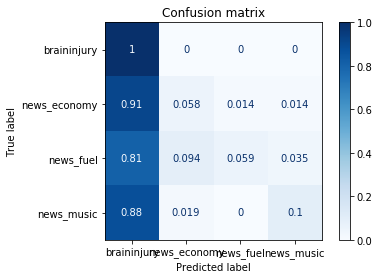

In [17]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                                 display_labels=topics,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title('Confusion matrix')

**Which class is the hardest one to recognize?**

Hardest to recoginze is `news_fuel`, it has lowest f1-score

### 2.6 Bonus task

What if we trained our `doc2vec` model using window size = 5 or 10? Would it improve the classification acccuracy? What about vector dimensionality? Does it mean that increasing it we will achieve better performance in terms of classification?

Explore the influence of these parameters on classification performance, visualizing it as a graph (e.g. window size vs f1-score, vector dim vs f1-score).

In [ ]:
#TODO bonus task